In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from bayes_opt import BayesianOptimization
import loggingScoring as ls
import matplotlib.pyplot as plt
import seaborn as sns

### Initiating Logging

In [2]:
log = ls.get_logfile('4.log')
log.info('Gradient Boosting Classifier')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

In [4]:
default_params = GradientBoostingClassifier().get_params()
print('Default Parameters of GradientBoostingClassifier :\n{}'.format(default_params))

Default Parameters of GradientBoostingClassifier :
{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


Fit time: 30.913 s / Predict time: 0.016 s ---- Precision: 0.907 / Recall: 0.893 / Accuracy: 0.905

Classification Report :

              precision    recall  f1-score   support

        Real       0.90      0.92      0.91      3187
        Fake       0.91      0.89      0.90      2936

    accuracy                           0.90      6123
   macro avg       0.91      0.90      0.90      6123
weighted avg       0.90      0.90      0.90      6123

ROC AUC Score : 0.9044934868235996


Confusion Matrix :



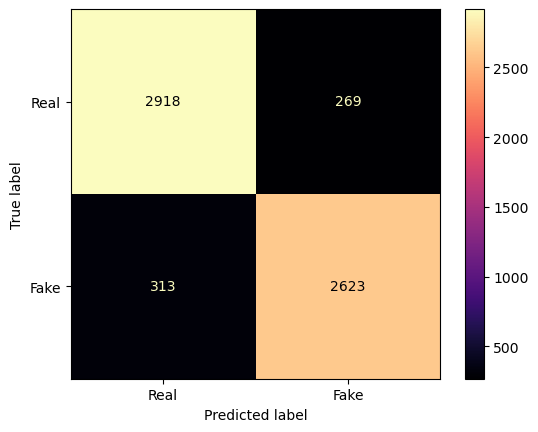

In [5]:
gb = GradientBoostingClassifier(random_state = 76)

start = time.time()
gb_model = gb.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [6]:
new_params = gb_model.get_params()
del new_params['random_state'], default_params['random_state']
# since we are manually setting random_state, removing that from comparison
if (default_params == new_params):
    print('No change observed in the Default Gradient Boosting Classifier',\
                                    'parameters after fitting the data.')
else:
    print('Default Gradient Boosting Classifier changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

No change observed in the Default Gradient Boosting Classifier parameters after fitting the data.


The Default Gradient Boosting Classifier performed much worse than the baseline, worst so far of all the classification models we have tested. Let's see if we can improve the scores through Hyperparameter Tuning.

### Hypeparameter Tuning

I am going to use Bayesian Optimization to find the best hypeparameters. I already tested it out with Random Forest and found that it was able to quickly zero in on the best values that were very close to what Grid Search had found (in fact the best Grid Search model and the best Bayesian Optimization model scored the same on test set) - while consuming very little time. We will follow the same approach here.

In [7]:
def classifier_crossval_function(n_estimators, max_depth, learning_rate, max_features, min_samples_leaf, min_samples_split):
    '''
        this is the function the optimizer will call
        the inputs for this function will be provided by the optimizer
        the inputs are basically the parameters within the range that we have provided
        the inputs can be (and mostly are) floats, if classifier requires discrete (int) values - they need to be adjusted
        the function should be able to modify the inputs as per the requirements of the classifier
        then the classifer instance is instantiated with these provided parameters
        and cross validated on training dataset
        the return of the function is the mean score of the cross validation on training set
        the Bayesian Optimizer will basically try to maximize this mean score
    '''
    
    print(f'Raw Parameters : {n_estimators = }, {max_depth = }, {learning_rate = },' +\
              f' {max_features = }, {min_samples_leaf = }, {min_samples_split = }.')
    
    # modify the hyperparameters to what Gradient Boosting Classifier needs
    n_estimators = round(n_estimators) # possible float to int
    max_depth = round(max_depth) # possible float to int
    # learning rate does not need a change
    max_features = round(max_features) # possible float to int
    min_samples_leaf = round(min_samples_leaf) # possible float to int
    min_samples_split = round(min_samples_split) # possible float to int
    
    print(f'Changed Parameters : {n_estimators = }, {max_depth = }, {learning_rate = },' +\
              f' {max_features = }, {min_samples_leaf = }, {min_samples_split = }.')
    
    gb_cv = GradientBoostingClassifier(n_estimators = n_estimators,
                                       max_depth = max_depth,
                                       learning_rate = learning_rate,
                                       max_features = max_features,
                                       min_samples_leaf = min_samples_leaf,
                                       min_samples_split = min_samples_split,
                                       random_state = 76)
    skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)
    
    scores = cross_val_score(estimator = gb_cv,
                             X = X_train,
                             y = y_train,
                             scoring = 'accuracy',
                             cv = skf,
                             verbose = 0)
    mean_score = scores.mean()
    
    print(f'Score : {mean_score}.')
    return mean_score

In [8]:
params_limit = {
    'n_estimators': (50, 5000),
    'max_depth': (5, 100),
    # tree depth would be smaller for Gradient Boost than what we used for Random Forest
    'learning_rate' : (0.001, 0.5),
    'max_features' : (1, 280),
    # this is actually the per tree feature count, will be converted into int
    # the logic behind the  highest value (280) was detailed in the Random Forest (BO) notebook 
    'min_samples_leaf' : (1, 100),
    'min_samples_split' : (2, 150)
    # The 'min_samples_split' parameter of GradientBoostingClassifier must be an int in the range [2, inf)
    # or a float in the range (0.0, 1.0].
}

bo = BayesianOptimization(f = classifier_crossval_function,
                          pbounds = params_limit,
                          random_state = 76,
                          verbose = 1)

In [9]:
# maximizing classifier_crossval_function
# diverting output to log
ls.divert_stdOut2log(log)
bo.maximize(init_points = 10, n_iter = 80)
ls.revert_log2stdOut()
print(bo.max)

{'target': 0.9531359401610393, 'params': {'learning_rate': 0.16384242582435987, 'max_depth': 97.43207751636909, 'max_features': 235.418311565676, 'min_samples_leaf': 5.515499889578504, 'min_samples_split': 141.80355459262458, 'n_estimators': 2513.543569903028}}


In [12]:
# saving the results
# bo.res is a list of dictionaries, in which params is another dictionary
# attempting to flatten the structure, before converting it into a dataframe
flattened_list = []
for res in bo.res:
    flattened_dict = {}
    flattened_dict['learning_rate'] = res['params']['learning_rate']
    flattened_dict['max_depth'] = round(res['params']['max_depth'])
    flattened_dict['max_features'] = round(res['params']['max_features'])
    flattened_dict['min_samples_leaf'] = round(res['params']['min_samples_leaf'])
    flattened_dict['min_samples_split'] = round(res['params']['min_samples_split'])
    flattened_dict['n_estimators'] = round(res['params']['n_estimators'])
    flattened_dict['mean_test_score'] = res['target']
    flattened_list.append(flattened_dict)
df_results = pd.DataFrame(flattened_list).sort_values('mean_test_score', ascending = False)
df_results.to_csv(datapath / 'HPTuningResults' / 'GradientBoosting_cv-results.csv', index = False)
df_results.head()

,learning_rate,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_test_score
39,0.163842,97,235,6,142,2514,0.953136
26,0.200684,92,280,7,23,1272,0.952905
52,0.071966,49,272,24,95,574,0.952848
67,0.147821,27,148,4,19,1163,0.952704
48,0.101710,58,195,21,55,603,0.952588


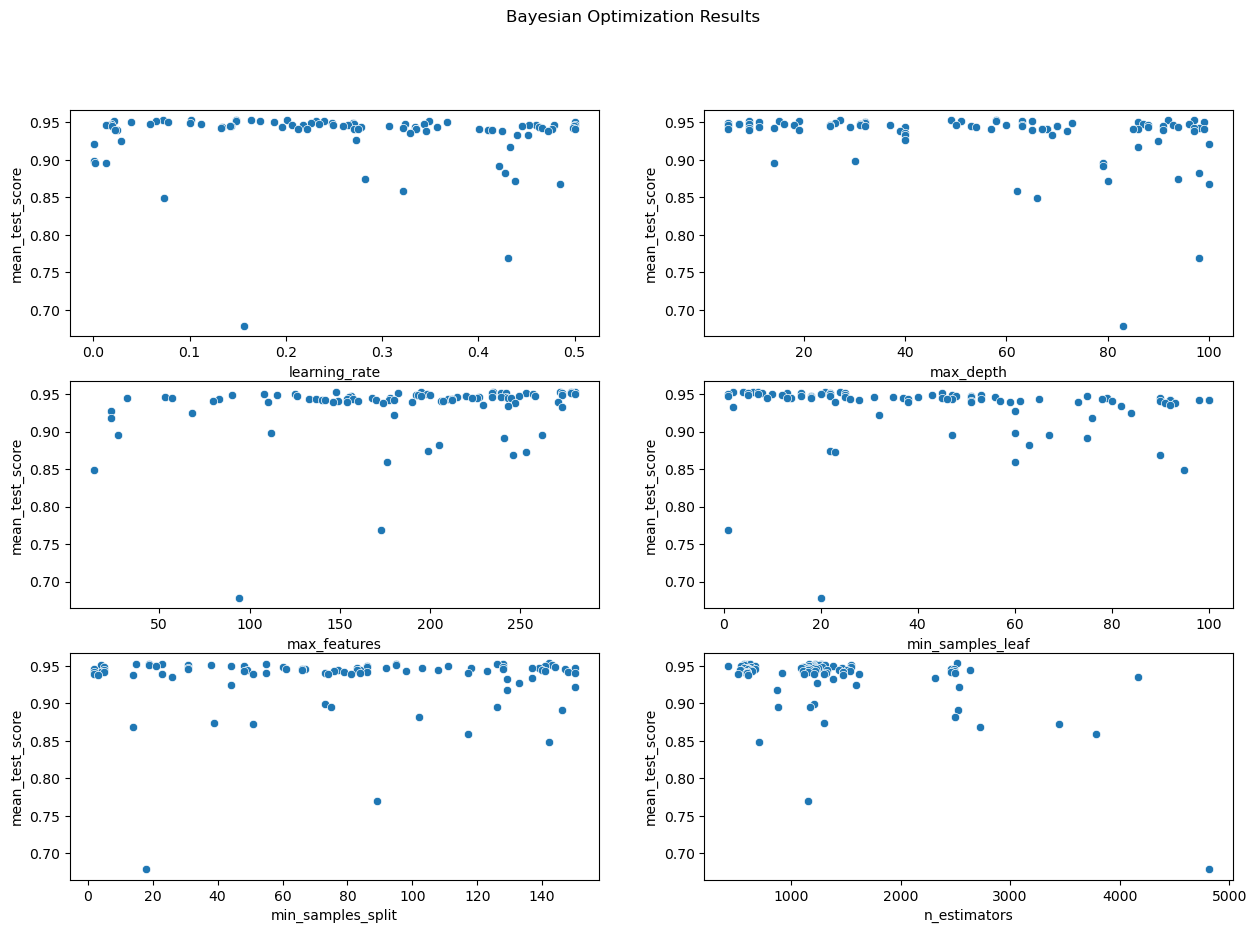

In [13]:
# visualizing the parameter space
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (15, 10))
sns.scatterplot(data = df_results, x = 'learning_rate', y = 'mean_test_score', ax = axes[0, 0])
sns.scatterplot(data = df_results, x = 'max_depth', y = 'mean_test_score', ax = axes[0, 1])
sns.scatterplot(data = df_results, x = 'max_features', y = 'mean_test_score', ax = axes[1, 0])
sns.scatterplot(data = df_results, x = 'min_samples_leaf', y = 'mean_test_score', ax = axes[1, 1])
sns.scatterplot(data = df_results, x = 'min_samples_split', y = 'mean_test_score', ax = axes[2, 0])
sns.scatterplot(data = df_results, x = 'n_estimators', y = 'mean_test_score', ax = axes[2, 1])

fig.suptitle('Bayesian Optimization Results')
plt.show()
plt.close()

### Best Model

Fit time: 194.888 s / Predict time: 7.852 s ---- Precision: 0.955 / Recall: 0.95 / Accuracy: 0.955

Classification Report :

              precision    recall  f1-score   support

        Real       0.95      0.96      0.96      3187
        Fake       0.95      0.95      0.95      2936

    accuracy                           0.95      6123
   macro avg       0.95      0.95      0.95      6123
weighted avg       0.95      0.95      0.95      6123

ROC AUC Score : 0.9544271089379625


Confusion Matrix :



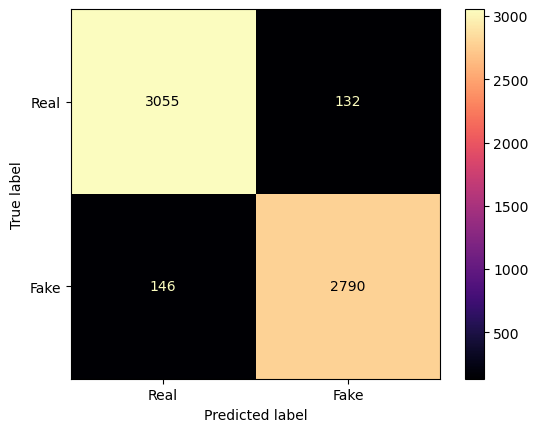

In [14]:
gb_best = GradientBoostingClassifier(learning_rate = 0.16384,
                                     max_depth = 97,
                                     max_features = 235,
                                     min_samples_leaf = 6,
                                     min_samples_split = 142,
                                     n_estimators = 2514,
                                     random_state=76)

start = time.time()
gb_model_best = gb_best.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_best = gb_model_best.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred_best, fit_time, pred_time)

Score of the best model is quite an improvement over the default model.